# Task4 HYPERSPECTRAL CLASSIFICATION——PART2

### 本任务的目的是学习高光谱数据的处理构建语义分割网络实现高光谱分类。

1. 了解遥感数据读写方法
2. 高光谱处理技术
3. 样本增广策略
4. 大区域目标推理策略

In [6]:
from tensorflow.keras import backend as K
import os
import numpy as np
import random
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,BatchNormalization,ZeroPadding2D,add, Flatten,Activation,AveragePooling2D,Dense
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,CSVLogger,ReduceLROnPlateau
from tensorflow.keras.layers import Lambda
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import time
from all_model import all_model
from utils import *
# from historycal import LossHistory
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# load data

In [22]:
hdf5_path = "Y:\\Deep learning teaching\\task4\\data\\hyper_pca_6b_4c_288.hdf5" 
fd = h5py.File(hdf5_path)
fd.keys()
images,labels=np.asarray(fd['image']),np.asarray(fd['label'])
# images,labels=np.asarray((fd['image'])[:20000]),np.asarray((fd['label'])[:20000])
fd.close()
n_label=5
print(images.shape,labels.shape)
# plot_func(images/2500,np.expand_dims(labels,axis=3))

(288, 256, 256, 6) (288, 256, 256)


D:\Anaconda3\envs\tf20\lib\site-packages\ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


389.0 3934.0
0.0 23896.0
(201, 256, 256, 6) (87, 256, 256, 6) (201, 256, 256, 5) (87, 256, 256, 5)


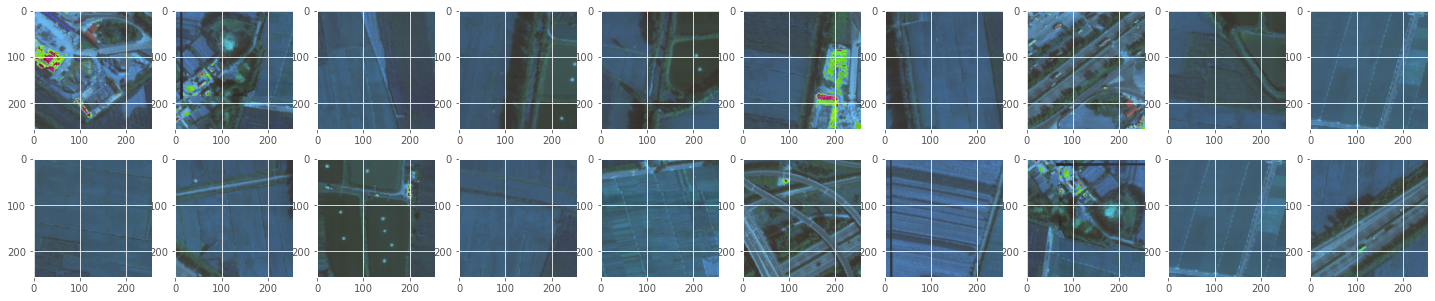

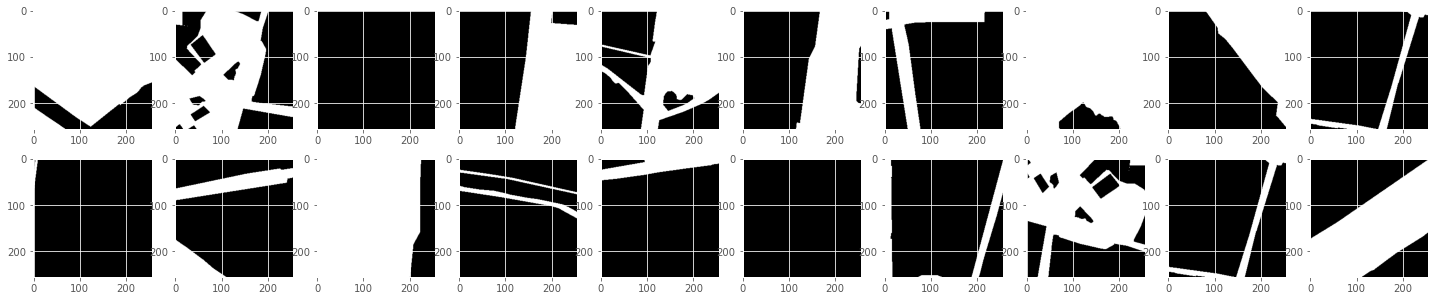

In [23]:
img,msk = get_normalized_patches(images,labels,3,10000,32000,n_label=n_label)
threshold=288
xtrain,xtest,ytrain,ytest=train_test_split(img[:threshold],msk[:threshold],test_size=0.3,shuffle=True,random_state=42)
# xval,yval=img[threshold:],msk[threshold:]
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
# del img,msk,images,labels
plot_func(xtrain*4,ytrain)

# Model set

In [31]:
loss='categorical_crossentropy'#'binary_crossentropy'
optimizer=Adam()#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#Adam()#SGD(),Adamax(),Adadelta()R
loss_weights=''
metrics=['accuracy']
input_height=256
input_width=256
batch_size=10
epoch=30
nclass=n_label
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel)
nickname='CBRRNET-tf2'

In [32]:
model=ATM.CBRRNET()#FCN8,UNET_VGG,UNET_MINI,SQUEESE_UNET,DEEPLABV3plus,CBRRNET
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 256, 256, 64) 448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_177 (BatchN (None, 256, 256, 64) 256         conv2d_150[0][0]                 
__________________________________________________________________________________________________
activation_176 (Activation)     (None, 256, 256, 64) 0           batch_normalization_177[0][0]    
____________________________________________________________________________________________

In [33]:
begin_time = time.time()          
checkpoint_DIR = "./checkpoint\\"
if not os.path.exists(checkpoint_DIR):
    os.makedirs(checkpoint_DIR) 
model_checkpoint = ModelCheckpoint(filepath=checkpoint_DIR+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
# histories=LossHistory()
csvlogger =CSVLogger(filename=checkpoint_DIR+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Epoch 1/30
21/21 [==============================] - 16s 446ms/step - loss: 0.9784 - accuracy: 0.6644 - val_loss: 10.3363 - val_accuracy: 0.0803
Epoch 2/30
21/21 [==============================] - 6s 304ms/step - loss: 0.4650 - accuracy: 0.8551 - val_loss: 2.2263 - val_accuracy: 0.3049
Epoch 3/30
21/21 [==============================] - 6s 304ms/step - loss: 0.4163 - accuracy: 0.8571 - val_loss: 2.9893 - val_accuracy: 0.3510
Epoch 4/30
21/21 [==============================] - 6s 305ms/step - loss: 0.3717 - accuracy: 0.8859 - val_loss: 2.9549 - val_accuracy: 0.3514
Epoch 5/30
21/21 [==============================] - 6s 307ms/step - loss: 0.3563 - accuracy: 0.8856 - val_loss: 1.1362 - val_accuracy: 0.5899
Epoch 6/30
21/21 [==============================] - 6s 305ms/step - loss: 0.3236 - accuracy: 0.8959 - val_loss: 0.4575 - val_accuracy: 0.8775
Epoch 7/30
21/21 [==============================] - 6s 307ms/step - loss: 0.2972 - accuracy: 0.9035 - val_loss: 0.6563 - val_accuracy: 0.7333
Epoc

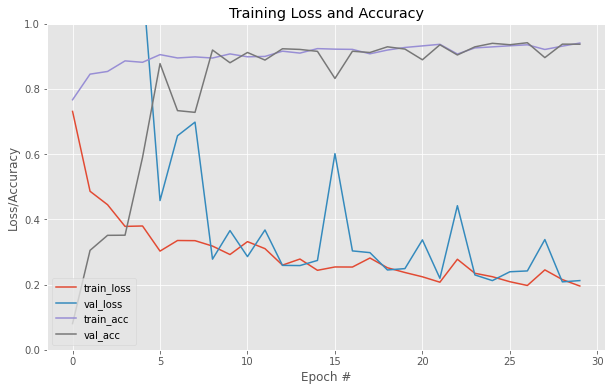

In [34]:
def plot_fig(H,outdir):
    N=len(result.history['loss'])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.ylim(0,1)

    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(outdir)
plot_fig(result,nickname+"_Loss_Acc_epoch.png")

# Prediction

In [36]:
inputdata='Y:\\Deep learning teaching\\task4\\data\\hyper_pca_6b_5c.tif'
img_file, img_bands, img_height, img_width, img_arr, geomatrix, projection = Load_image_by_Gdal(inputdata)
newimg=img_arr.transpose(( 1, 2,0))
newimg=np.expand_dims(newimg,axis=0)
normdata=data_split(newimg[:,:,:,:-1],3,10000,32000)
testlabel=newimg[:,:,:,-1]
PREDICTION_DIR = "./prediction\\"+nickname+'\\'
if not os.path.exists(PREDICTION_DIR):
    os.makedirs(PREDICTION_DIR)

print("[INFO] finish loading!")
begin_time = time.time()   
normdata.reshape((normdata.shape[1:]))
model=load_model('./checkpoint\\CBRRNET-tf2-29e-val_loss0.208328.hdf5')
outfile=PREDICTION_DIR+nickname+'_'+str(n_label)+'_pred.tif'
msk_result,mask_arr=predict(model,normdata.reshape(normdata.shape[1:]),PREDICTION_DIR,nickname,0.5,n_label)
resulttif=(mask_arr.transpose(( 2,0,1)))*10000
result=np.asarray(resulttif,dtype='uint16')
Write_Tiff(result, geomatrix, projection,outfile)
argmax_out(result,geomatrix,projection,PREDICTION_DIR+nickname+'_'+str(n_label)+'_class.tif',5000)

loadtime=end_time - begin_time
print('time lapsing {0} s \n'.format(loadtime))


all images=1680
processing.....0    of   40
processing.....10    of   40
processing.....20    of   40
processing.....30    of   40
./prediction\CBRRNET-tf2\CBRRNET-tf2_5_pred.tif 5348 5034 5 2
(5, 5034, 5348) 1
./prediction\CBRRNET-tf2\CBRRNET-tf2_5_class.tif 5348 5034 1 6
time lapsing -220.84280395507812 s 



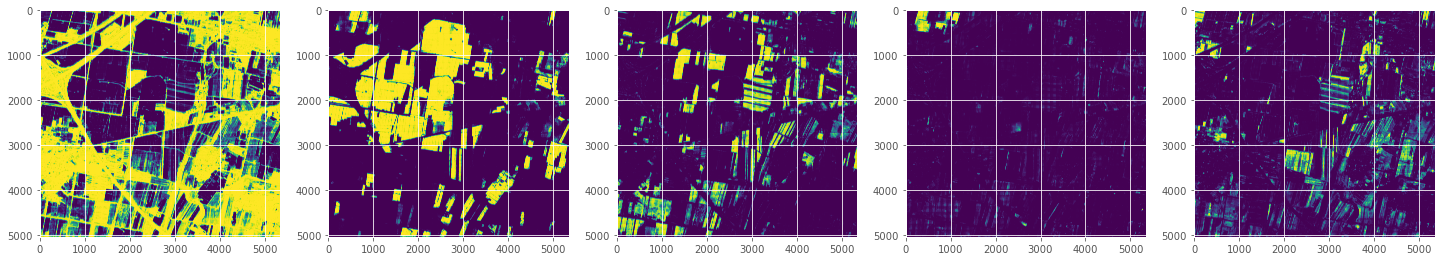

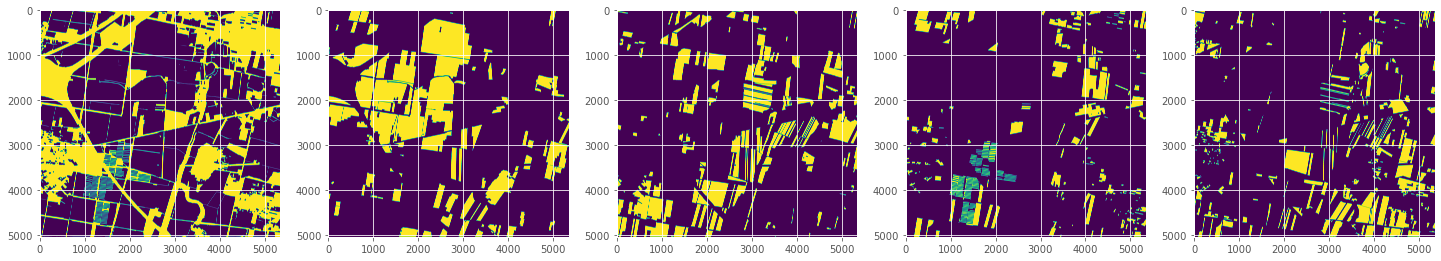

In [37]:
plot_label_func(mask_arr,(label_hot(testlabel,n_label))[0,:,:,:],n_label)